<h1 style="font-size: 22px; line-height: 100%; text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142); border-radius: 10px;">
Automated Neural Architecture Search with BootstrapNAS
</h1>

This notebook demonstrates how to use [BootstrapNAS](https://arxiv.org/abs/2112.10878), a capability in NNCF to generate weight-sharing super-networks from pre-trained models. Once the super-network has been generated, BootstrapNAS can train it and search for efficient sub-networks.

<p align="center">
<img src="./imgs/architecture.png" alt="BootstrapNAS Architecture" width="90%"/>
</p>

As illustrated in the figure above, BootstrapNAS (1) takes as input a pre-trained model. (2) It uses this model to generate a weight-sharing super-network. (3) BootstrapNAS then applies a training strategy, and once the super-network has been trained, (4) it searches for efficient subnetworks that satisfy the user's requirements. (5) The configuration of the discovered sub-network(s) is returned to the user.

We will use [ResNet-50](https://arxiv.org/abs/1512.03385) as input pre-trained model. Our goal is to discover alternative models, a.k.a., subnetworks, that are more efficient than the input pre-trained model. In this example, the model has been trained with CIFAR-10. 

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Imports and Settings
</h3>

First, we need to import NNCF and all auxiliary packages to our Python code. Set a name for the model, and the image width and height that will be used for the network. Also define paths where the output files will be stored. 
<!-- > NOTE: All NNCF logging messages below ERROR level (INFO and WARNING) are disabled to simplify the tutorial. For production use, it is recommended to enable logging, by removing ```set_log_level(logging.ERROR)```. -->

In [1]:
from imports_bnas import * # Import NNCF, PyTorch and other required packages.   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_DIR = Path("../../models/pretrained")
OUTPUT_DIR = Path("output")
DATA_DIR = Path("data")
BASE_MODEL_NAME = "resnet-50"

fp32_pth_path, model_onnx_path, supernet_onnx_path, subnet_onnx_path = create_folders_demo(BASE_MODEL_NAME)

Imported PyTorch and NNCF


<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
    Download the Weights for the Pre-trained Model
</h3>
    
You can obtain weights for several models trained with CIFAR-10 from this [Git repository](https://github.com/huyvnphan/PyTorch_CIFAR10). For your convenience, we have extracted the weight for ResNet-50. 

In [2]:
fp32_pth_url = "../../models/pretrained/resnet50.pt"

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
Prepare the Dataset
</h3>
    
Next, prepare the CIFAR-10 dataset. The CIFAR-10 dataset contains:
* 60,000 images of shape 3x32x32
* 10 different classes (6,000 images per class): airplane, automobile, etc. 

Here, the dataloader is created for both the training and validation dataset which includes normalization, crop, and other transformation.  Each dataloader uses 4 workers and a batch size of 64 for training and 1000 for validation.

In [3]:
DATASET_DIR = DATA_DIR / "cifar10"

batch_size_val = 1000
batch_size = 64
train_loader, val_loader = create_cifar10_dataloader(DATASET_DIR, batch_size, batch_size_val, device)

<h1 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 5px solid rgb(36, 24, 142);
border-radius: 25px;
">
Generate a super-network from a pre-trained model
</h1>
 
<!-- Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline. Next, we demonstrate one possible training pipeline. -->

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
Load the Pre-trained Model
</h3>

In [4]:
model = resnet50_cifar10()
state_dict = torch.load(fp32_pth_url)
model.load_state_dict(state_dict)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
    Evaluate the Pre-trained Model
</h3>
    
    We want to evaluate the pre-trained model using the validation dataset to have a reference of how the model performs, and then to use BootstrapNAS to discover an alternative model that might outperform this input model.

In [5]:
model_top1_acc, _, _ = validate(model, val_loader) 

Test: [ 0/10]	Time 0.562 (0.562)	Loss 0.234 (0.234)	Acc@1 93.70 (93.70)	Acc@5 99.90 (99.90)
 * Acc@1 93.660 Acc@5 99.810


The input pre-trained model has a top 1 accuracy of **93.66%**. We will use BootstrapNAS to find a sub-network with similar accuracy but more efficient. 

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
Generate and Train the Super-network
</h3>

We use the pre-trained MobileNet-V2 model to generate a weight-sharing super-network. We define a configuration that contains details about the super-network desired structure and how it will be trained.

In [6]:
config = {
            "device": device,
            "input_info": {
                "sample_size": [1, 3, 32, 32],
            },
            "checkpoint_save_dir": OUTPUT_DIR,
            "bootstrapNAS": {
                "training": {
                    "batchnorm_adaptation": {
                        "num_bn_adaptation_samples": 2
                    },
                    "schedule": {
                        "list_stage_descriptions": [
                            {"train_dims": ["depth"], "epochs": 1, "init_lr": 2.5e-6},
                        ]
                    },
                    "elasticity": {
                        "available_elasticity_dims": ["width", "depth"]
                    },
                },
                "search": {
                    "algorithm": "NSGA2",
                    "num_evals": 5, 
                    "population": 2, 
                    "ref_acc": model_top1_acc.item(),
                    "acc_delta": 4
                }
            }
        }

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

# Generate and train the super-network
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nncf_config = NNCFConfig.from_dict(config)

    bn_adapt_args = BNAdaptationInitArgs(data_loader=wrap_dataloader_for_init(train_loader), device=device)
    nncf_config.register_extra_structs([bn_adapt_args])
  
    # Super-network generation
    nncf_network = create_nncf_network(model, nncf_config)

    # Training
    train_steps = 10
    def train_epoch_fn(loader, model, compression_ctrl, epoch, optimizer):
        train_epoch(loader, model, device, criterion, optimizer, epoch, compression_ctrl, train_iters=train_steps)

    training_algorithm = EpochBasedTrainingAlgorithm.from_config(nncf_network, nncf_config)
    nncf_network, elasticity_ctrl = training_algorithm.run(train_epoch_fn, train_loader,
                                                           validate, val_loader, optimizer,
                                                           OUTPUT_DIR, None,
                                                           train_steps)

Called Initialize
Epoch:[0][  0/781]	Time 0.681 (0.681)	Loss 1.084 (1.084)	Acc@1 65.62 (65.62)	Acc@5 93.75 (93.75)
Test: [ 0/10]	Time 0.425 (0.425)	Loss 0.938 (0.938)	Acc@1 85.70 (85.70)	Acc@5 99.20 (99.20)
 * Acc@1 86.130 Acc@5 98.650
Test: [ 0/10]	Time 0.432 (0.432)	Loss 0.303 (0.303)	Acc@1 92.90 (92.90)	Acc@5 99.60 (99.60)
 * Acc@1 93.100 Acc@5 99.690


<h1 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 5px solid rgb(36, 24, 142);
border-radius: 25px;
">
Search for Efficient Sub-networks
</h1>

Once the super-network has been trained, we use NSGA2, as specified in the configuration above, to search for efficient sub-networks that satisfy the user's requirements. The configuration of the discovered sub-network(s) and ther performance metrics will be returned to the user. In addition to NSGA2, the user could implement her own search algorithm using any other multi-objective optimization approach. 

In [8]:
search_algo = SearchAlgorithm.from_config(nncf_network, elasticity_ctrl, nncf_config)

def validate_model_fn_top1(model, val_loader):
    top1, _, _ = validate(model, val_loader, criterion)
    return top1.item()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    elasticity_ctrl, best_config, performance_metrics = search_algo.run(validate_model_fn_top1, val_loader,
                                                                        OUTPUT_DIR,
                                                                        tensorboard_writer=None)

print("Best config: {best_config}".format(best_config=best_config))
print("Performance metrics: {performance_metrics}".format(performance_metrics=performance_metrics))


Test: [ 0/10]	Time 0.442 (0.442)	Loss 0.303 (0.303)	Acc@1 92.90 (92.90)	Acc@5 99.60 (99.60)
 * Acc@1 93.100 Acc@5 99.690
Test: [ 0/10]	Time 0.464 (0.464)	Loss 0.340 (0.340)	Acc@1 91.20 (91.20)	Acc@5 99.40 (99.40)
 * Acc@1 91.780 Acc@5 99.580
Test: [ 0/10]	Time 0.462 (0.462)	Loss 0.290 (0.290)	Acc@1 92.40 (92.40)	Acc@5 99.60 (99.60)
 * Acc@1 92.850 Acc@5 99.750
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |       2 |       2 |            - |            -
Test: [ 0/10]	Time 0.430 (0.430)	Loss 0.526 (0.526)	Acc@1 88.10 (88.10)	Acc@5 99.60 (99.60)
 * Acc@1 88.640 Acc@5 99.410
Test: [ 0/10]	Time 0.440 (0.440)	Loss 0.238 (0.238)	Acc@1 92.60 (92.60)	Acc@5 99.90 (99.90)
 * Acc@1 92.870 Acc@5 99.780
    2 |       4 |       2 |  1.000000000 |        ideal
Best config: OrderedDict([(<ElasticityDim.DEPTH: 'depth'>, [4])])
Performance metrics: [307.974144, 91.77999877929688]


<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
Visualization of the Search Stage
</h3>    
    
After the search has concluded, we can visualize the search progression phase.

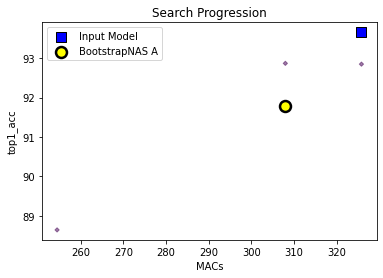

In [9]:
search_algo.visualize_search_progression(filename=Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_search")))

In the example above, we have used just a few epochs to train the super-network. Please refer to the `schedule` section in the configuration file. Increasing the number of training epochs and the elasticity of the super-newtwork will result in a greater search space from which we can extract efficient sub-networks. For instance, this is the result that we get by increasing the number of epochs and the elasticity of the super-network: 


<img src="./imgs/search_progression.png" alt="BootstrapNAS ResNet-50" width="600" align="center" />


As illustrated in the figure above, many sub-networks are more efficient than the original pre-trained model, and the user can choose whether to tolerate a drop in accuracy for more efficiency.

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;
">
Summary
</h3>

In this notebook, we have demonstrated NNCF's BootstrapNAS capability to generate and train weight-sharing super-networks, and the subsequent discovery of efficient sub-networks. BootstrapNAS is available at the [NNCF repository](https://github.com/openvinotoolkit/nncf/blob/develop/examples/experimental/torch/classification/Quickstart.md). 